## Crawling Data

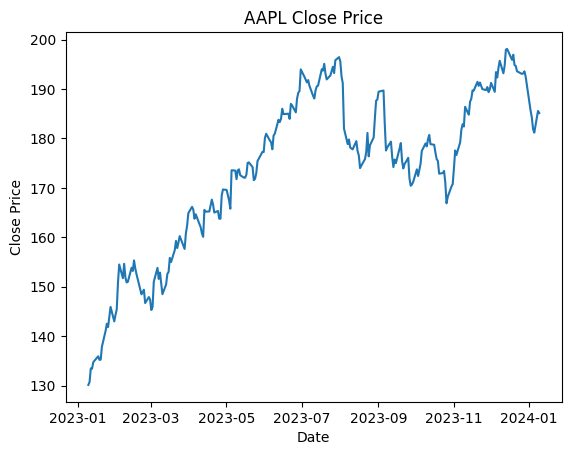

In [1]:
endpoints = 'https://api.polygon.io/v2/aggs/ticker/AAPL/range/1/day/2023-01-09/2024-01-09?adjusted=true&sort=asc&apiKey=ZfnOMH7o19qGt_nvIFKzTYRadxjFg7FL'
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# If the data is not stored, use requests to get the data
# After getting the data, save it to a file
# If that file exists, use the file to get the data
try:
    with open('AAPL.json', 'r') as f:
        data = json.load(f)
except:
    data = requests.get(endpoints).json()
    with open('AAPL.json', 'w') as f:
        json.dump(data, f)

# Convert the data to a pandas dataframe
df = pd.DataFrame(data['results'])

# Convert the timestamp to a datetime object
df['t'] = pd.to_datetime(df['t'], unit='ms')

# Plot the data
plt.plot(df['t'], df['c'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL Close Price')
plt.show()

In [2]:
df.head()

,v,vw,o,c,h,l,t,n
0,70790813.0,131.6292,130.465,130.15,133.4100,129.89,2023-01-09 05:00:00,645365
1,63896155.0,129.8220,130.260,130.73,131.2636,128.12,2023-01-10 05:00:00,554940
2,69458949.0,132.3081,131.250,133.49,133.5100,130.46,2023-01-11 05:00:00,561278
3,71379648.0,133.1710,133.880,133.41,134.2600,131.44,2023-01-12 05:00:00,635331
4,57809719.0,133.6773,132.030,134.76,134.9200,131.66,2023-01-13 05:00:00,537385


In [3]:
# Compute the volatility of the last 1 year period. Might need to fetch data for the previous year

# Get the data for the previous year
endpoints = 'https://api.polygon.io/v2/aggs/ticker/AAPL/range/1/day/2022-01-09/2023-01-09?adjusted=true&sort=asc&apiKey=ZfnOMH7o19qGt_nvIFKzTYRadxjFg7FL'
try:
    with open('AAPL_1_year.json', 'r') as f:
        data = json.load(f)
except:
    data = requests.get(endpoints).json()
    with open('AAPL_1_year.json', 'w') as f:
        json.dump(data, f)

# Convert the data to a pandas dataframe
df_prev = pd.DataFrame(data['results'])

# Convert the timestamp to a datetime object
df_prev['t'] = pd.to_datetime(df['t'], unit='ms')

# Compute the volatility, the standard deviation of the rate of return
df_prev['rate_of_return'] = df_prev['c'].pct_change()
volatility = np.std(df_prev['rate_of_return'])
print(f'The volatility of the last year is: {volatility}')

The volatility of the last year is: 0.02488428708270036


## Computing $S_f(t)$

#### American Option

- Expiry date: 09/01/2024
- Strike Price: 150
- T: 1
- r: 5\%
- D: 2%
- $\sigma$: 0.024


In [4]:
dividend = 0.98
strike_price = 150
volatility = 0.024
risk_free_rate = 0.05
time_to_maturity = 1

In [5]:
import numpy as np
from scipy.stats import norm
from scipy.special import erf

# The CDF of the standard normal distribution
def phi(z):
    return (1.0 + erf(z / np.sqrt(2.0))) / 2.0

def d1(x, y, z):
    return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))

def d2(x, y, z):
    return d1(x, y, z) - volatility * np.sqrt(y)

def Q1(x, y, z, w):
    x = float(x)
    result = x * dividend * np.exp(-dividend * (z - y)) * phi(d1(x, z - y, w))
    result -= strike_price * np.exp(-risk_free_rate * (z - y)) * phi(d2(x, z - y, w))
    return result

def Q1_derivative_x(x, y, z, w):
    # Derivative of Q1 with respect to x using five-point stencil method
    h = 1e-5
    return (-Q1(x + 2*h, y, z, w) + 8*Q1(x + h, y, z, w) - 8*Q1(x - h, y, z, w) + Q1(x - 2*h, y, z, w)) / (12 * h)

def M1(x, y, z):
    x = float(x)
    result = x * np.exp(-dividend * y) * phi(d1(x, y, z)) - strike_price * np.exp(-risk_free_rate * y) * phi(d2(x, y, z))
    return result

def M1_derivative_x(x, y, z):
    # Derivative of M1 with respect to x using five-point stencil method
    h = 1e-5
    return (-M1(x + 2*h, y, z) + 8*M1(x + h, y, z) - 8*M1(x - h, y, z) + M1(x - 2*h, y, z)) / (12 * h)

In [6]:
def newton_raphson(f, f_prime, x0, tol=1e-3, max_iter=100):
    x = x0
    for _ in range(max_iter):
        fx = f(x)
        fpx = f_prime(x)
        if abs(fpx) < tol:
            raise ValueError("Derivative too small; no convergence.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    return x

In [7]:
stock_price_list = df['c'].values
s_f_list = []
s_f_list.append([0] * len(stock_price_list))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
trading_days = 252
for i in range(len(stock_price_list) - 2, -1, -1):
    time_passed = (i + 1) / trading_days
    guess_x = s_f_list[i + 1]
    print(M1(guess_x, 1.0/trading_days, strike_price))
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1.0/trading_days, strike_price)
        test_result -= (1/(trading_days * 2)) * Q1(x, time_passed, time_passed + 1.0/trading_days, strike_price)
        test_result -= (1/(trading_days * 2)) * (1/2 * x * dividend - strike_price)
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1.0/trading_days, strike_price)
        derivative_result -= (1/(trading_days*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/trading_days, strike_price)
        derivative_result -= (1/(trading_days*2)) * 1/2 * dividend
        return derivative_result
    
    s_f_list[i] = newton_raphson(test_sf, test_sf_derivative, guess_x)

s_f_list


0.000543703473161905
5.806945639011407e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844125111e-05
5.806945844

[np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float64(149.84811927400514),
 np.float6

Text(0.5, 0, 'Date')

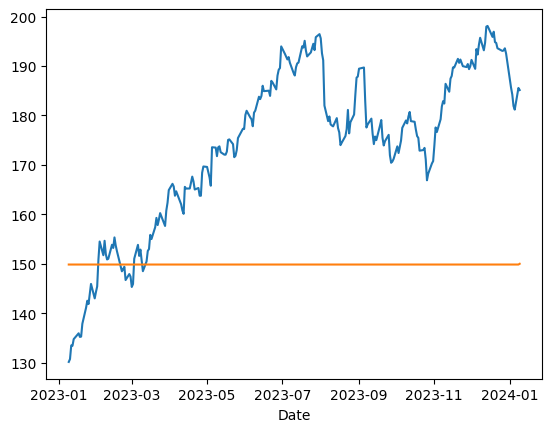

In [8]:
# Graph the stock price and the optimal exercise boundary
plt.plot(df['t'], df['c'], label='Stock Price')
plt.plot(df['t'], s_f_list, label='Optimal Exercise Boundary')
plt.xlabel('Date')

Toy problem

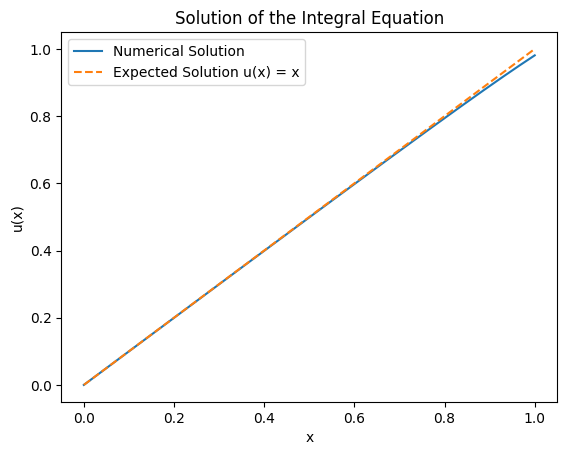

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Newton-Raphson method
def newton_raphson(f, f_prime, x0, tol=1e-7, max_iter=100):
    x = x0
    for _ in range(max_iter):
        fx = f(x)
        fpx = f_prime(x)
        if abs(fpx) < tol:
            raise ValueError("Derivative too small; no convergence.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    return x

# Discretization parameters
number_of_discretizations = 1000
time_domain = np.linspace(0, 1, number_of_discretizations)
time_interval = 1.0 / number_of_discretizations

# Function definitions
def f(x):
    return 2 * x - 2 * x * np.exp(x) + np.exp(x) - 1

def K(x, t, ut):
    return (x + t) * np.exp(ut)

# Function to be zeroed in Newton-Raphson
def test(t2, ut2, values):
    integral_sum = sum(K(t2, time_domain[j], values[j]) * time_interval for j in range(len(values)))
    return f(t2) - ut2 + integral_sum

# Derivative of test with respect to ut2
def test_derivative(t2, ut2):
    return -1 - time_interval * t2 * np.exp(ut2)

# Initial conditions and iterative solution
values = [f(0)]
for i in range(1, number_of_discretizations):
    t2 = time_domain[i]
    guess = values[-1]  # Use last calculated value as initial guess
    # Newton-Raphson to solve for u(t2)
    u_t2 = newton_raphson(lambda x: test(t2, x, values), 
                          lambda x: test_derivative(t2, x), 
                          guess)
    values.append(u_t2)

# Plot the solution
plt.plot(time_domain, values, label='Numerical Solution')
plt.plot(time_domain, time_domain, '--', label='Expected Solution u(x) = x')
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Solution of the Integral Equation")
plt.show()

Big problem

In [10]:
dividend = 0.02
strike_price = 100
volatility = 0.2
risk_free_rate = 0.05
time_to_maturity = 1

In [11]:
import numpy as np
from scipy.stats import norm
from scipy.special import erf

# The CDF of the standard normal distribution
def phi(z):
    return (1.0 + erf(z / np.sqrt(2.0))) / 2.0

def d1(x, y, z):
    return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))

def d2(x, y, z):
    return d1(x, y, z) - volatility * np.sqrt(y)

def Q1(x, y, z, w):
    x = float(x)
    result = x * dividend * np.exp(-dividend * (z - y)) * phi(d1(x, z - y, w))
    result -= risk_free_rate * strike_price * np.exp(-risk_free_rate * (z - y)) * phi(d2(x, z - y, w))
    return result

def Q1_derivative_x(x, y, z, w):
    # Derivative of Q1 with respect to x using five-point stencil method
    h = 1e-5
    return (-Q1(x + 2*h, y, z, w) + 8*Q1(x + h, y, z, w) - 8*Q1(x - h, y, z, w) + Q1(x - 2*h, y, z, w)) / (12 * h)

def M1(x, y, z):
    x = float(x)
    result = x * np.exp(-dividend * y) * phi(d1(x, y, z)) - strike_price * np.exp(-risk_free_rate * y) * phi(d2(x, y, z))
    return result

def M1_derivative_x(x, y, z):
    # Derivative of M1 with respect to x using five-point stencil method
    h = 1e-5
    return (-M1(x + 2*h, y, z) + 8*M1(x + h, y, z) - 8*M1(x - h, y, z) + M1(x - 2*h, y, z)) / (12 * h)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Newton-Raphson method
def newton_raphson(f, f_prime, x0, tol=1e-7, max_iter=100):
    x = x0
    for _ in range(max_iter):
        fx = f(x)
        fpx = f_prime(x)
        if abs(fpx) < tol:
            raise ValueError("Derivative too small; no convergence.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    return x

In [13]:
stock_price_list = df['c'].values
s_f_list = []
s_f_list.append([0] * len(stock_price_list))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
trading_days = 252
cumulative = 0
cnt=0
for i in range(len(stock_price_list) - 2, -1, -1):
    time_passed = i / trading_days
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(trading_days * 2)) * Q1(x, time_passed, time_passed + 1.0/trading_days, s_f_list[i + 1])
        test_result -= (1/(trading_days * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(stock_price_list) - 1, 1):
            test_result -= (1/(trading_days * 2)) * Q1(x, time_passed, j/trading_days, s_f_list[j])
            test_result -= (1/(trading_days * 2)) * Q1(x, time_passed, (j + 1)/trading_days, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(trading_days*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/trading_days, s_f_list[i + 1])
        derivative_result -= (1/(trading_days*2)) * 1/2 * dividend
        for j in range(i + 1, len(stock_price_list) - 1):
            derivative_result -= (1/(trading_days * 2)) * Q1_derivative_x(x, time_passed, j/trading_days, s_f_list[j])
            derivative_result -= (1/(trading_days * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/trading_days, s_f_list[j + 1])
        return derivative_result
    
    s_f_list[i] = newton_raphson(test_sf, test_sf_derivative, guess_x)



Text(0.5, 0, 'Date')

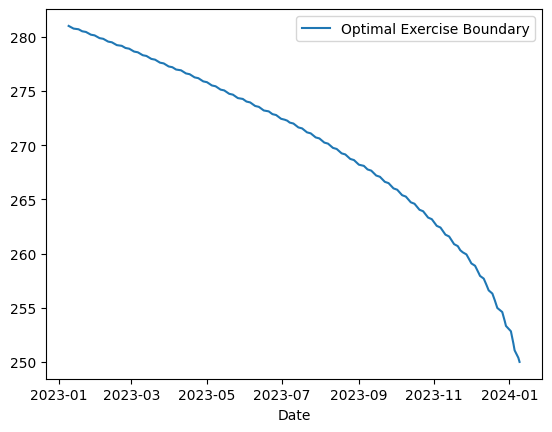

In [14]:
# Graph the stock price and the optimal exercise boundary
plt.plot(df['t'], s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Date')

In [15]:
import numpy as np

# Constants and Parameters
trading_days = 252
T = 1  # Total time in years
time_steps = len(stock_price_list)
x_domain = np.linspace(0, 500, 500)  # Asset prices

# Time step interval for Riemann sum
delta_t = 1 / trading_days

# Initialize V(S, t) matrix with zeros
V_matrix = np.zeros((len(x_domain), time_steps))

# Compute V(S, t) based on S_f(t)
for i, S in enumerate(x_domain):
    for t_idx in range(time_steps):
        # Determine time t and remaining time to maturity T - t
        time_t = t_idx / trading_days
        remaining_time = T - time_t

        # Optimal stopping price S_f at time t
        S_f_t = s_f_list[t_idx]

        if S > S_f_t:
            # If S > S_f, payoff is immediate
            V_matrix[i, t_idx] = S - strike_price
        else:
            # If S <= S_f, calculate M1 and the Riemann sum for the integral part
            M1_value = M1(S, remaining_time, strike_price)

            # Riemann sum approximation for the integral
            integral_part = 0
            for u_idx in range(t_idx, time_steps):
                u = u_idx / trading_days
                S_f_u = s_f_list[u_idx]  # Optimal exercise boundary at time u
                integral_part += Q1(S, time_t, u, S_f_u) * delta_t

            # Calculate V(S, t) for S <= S_f
            V_matrix[i, t_idx] = M1_value + integral_part

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30248\3227588999.py:10: RuntimeWarning: divide by zero encountered in log
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30248\3227588999.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))


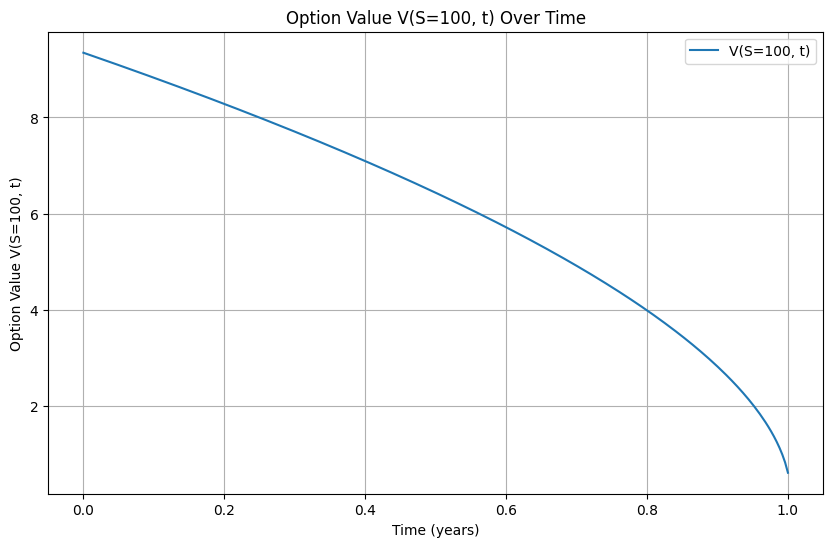

In [16]:
import matplotlib.pyplot as plt

# Find the index in x_domain closest to S = 100
S_target = 100
S_index = np.argmin(np.abs(x_domain - S_target))

# Extract V(S=100, t) over time from V_matrix
V_S_100_over_time = V_matrix[S_index, :]

# Generate time array in years for plotting
time_array = np.linspace(0, T, time_steps)

# Plot V(S=100, t) over time
plt.figure(figsize=(10, 6))
plt.plot(time_array, V_S_100_over_time, label=f'V(S={S_target}, t)')
plt.xlabel('Time (years)')
plt.ylabel(f'Option Value V(S={S_target}, t)')
plt.title(f'Option Value V(S={S_target}, t) Over Time')
plt.legend()
plt.grid(True)
plt.show()

Operator Splitting

In [17]:
import numpy as np
dividend = 0.02
strike_price = 100
volatility = 0.2
risk_free_rate = 0.05
time_to_maturity = 1

alpha = 1/2 # Crank-Nicolson parameter

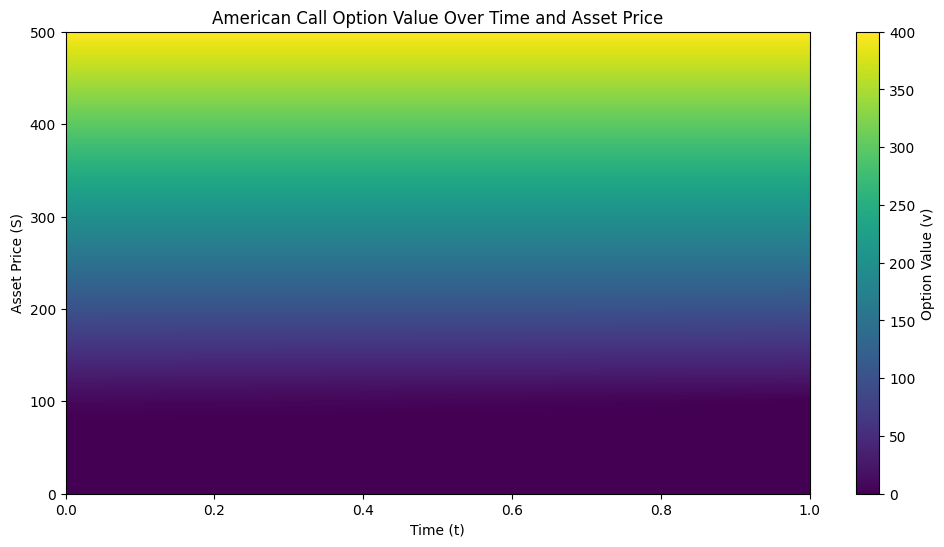

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x_domain = np.linspace(0, 500, 500)  # Asset prices
t_domain = np.linspace(0, 1, 1000)  # Time from 0 to T
time_interval = 1.0 / 1000

# Initial condition for v at T (payoff for an American call option)
v_T = np.maximum(x_domain - strike_price, 0)
lambda_T = np.zeros(len(x_domain))

# Matrix A setup for the finite difference method
A = np.zeros((len(x_domain), len(x_domain)))
for i in range(len(x_domain)):
    A[i, i] = - ((volatility * i)**2 + risk_free_rate)
    if i > 0:
        A[i, i - 1] = 0.5 * (((volatility * i)**2 - (risk_free_rate - dividend) * i))
    if i < len(x_domain) - 1:
        A[i, i + 1] = 0.5 * (((volatility * i)**2 + (risk_free_rate - dividend) * i))

# Storage array for the option values at each time step
v_matrix = np.zeros((len(t_domain), len(x_domain)))
v_matrix[-1, :] = v_T  # Set the terminal condition at t = T

# Backward time-stepping
for i in range(len(t_domain) - 2, -1, -1):
    t = t_domain[i]
    
    # Step 1: LU decomposition to find the intermediate step
    A_prime = -1 / time_interval * np.eye(len(x_domain)) + alpha * A
    B = 1 / time_interval * np.eye(len(x_domain)) + (1 - alpha) * A
    intermediate = np.linalg.solve(A_prime, -np.dot(B, v_T) + lambda_T)

    # Step 2: Projection step to enforce the early-exercise constraint
    v_new = np.copy(intermediate)  # Start with the intermediate values as a base
    for j in range(len(x_domain)):
        # Calculate the payoff at this point (for an American call, payoff = max(x - strike_price, 0))
        payoff = max(x_domain[j] - strike_price, 0)
        # Enforce the constraint: v >= payoff
        if v_new[j] + time_interval * lambda_T[j] < payoff:
            v_new[j] = payoff
            lambda_T[j] = max(lambda_T[j] + (1 / time_interval) * (intermediate[j] - v_new[j]), 0)
        else:
            v_new[j] = v_new[j] + time_interval * lambda_T[j]
            lambda_T[j] = 0
    # Update v_T for the next time step
    v_T = v_new
    # Store the new v_T in the matrix for plotting
    v_matrix[i, :] = v_T

# Plotting the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(v_matrix.T, extent=[0, 1, 0, 500], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Option Value (v)")
plt.xlabel("Time (t)")
plt.ylabel("Asset Price (S)")
plt.title("American Call Option Value Over Time and Asset Price")
plt.show()

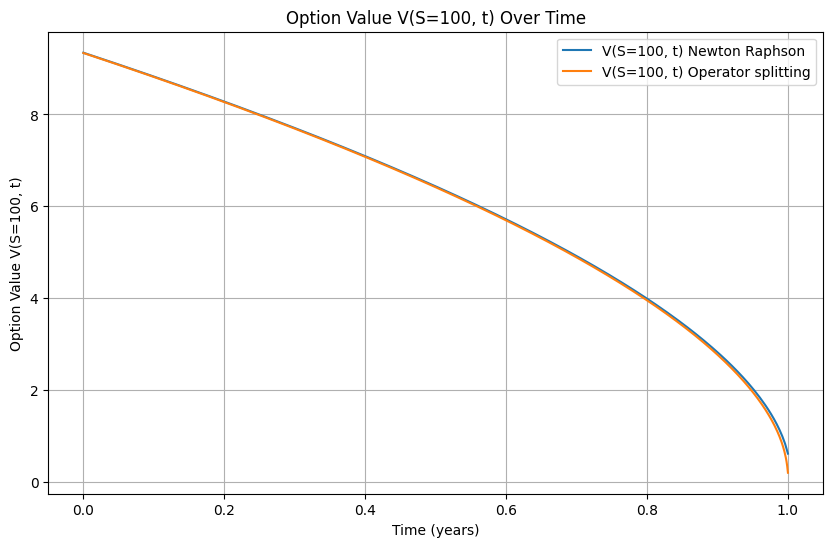

In [19]:
# Find the index in x_domain closest to S = 100
S_target = 100
S_index = np.argmin(np.abs(x_domain - S_target))

# Extract V(S=100, t) over time from V_matrix
V_S_100_over_time = V_matrix[S_index, :]

# Generate time array in years for plotting
time_array = np.linspace(0, T, time_steps)
plt.figure(figsize=(10, 6))
plt.plot(time_array, V_S_100_over_time, label=f'V(S={S_target}, t) Newton Raphson')
plt.plot(t_domain, v_matrix[:, S_index], label=f'V(S={S_target}, t) Operator splitting')
plt.xlabel('Time (years)')
plt.ylabel(f'Option Value V(S={S_target}, t)')
plt.title(f'Option Value V(S={S_target}, t) Over Time')
plt.legend()
plt.grid(True)
plt.show()

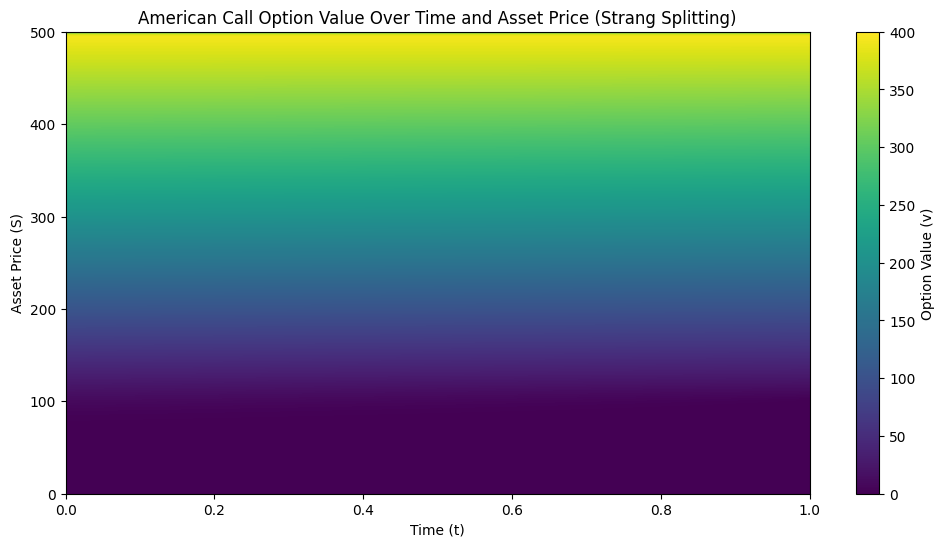

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x_domain = np.linspace(0, 500, 500)  # Asset prices
t_domain = np.linspace(0, 1, 1000)  # Time from 0 to T
time_interval = 1.0 / 1000

# Initial condition for v at T (payoff for an American call option)
v_T = np.maximum(x_domain - strike_price, 0)
lambda_T = np.zeros(len(x_domain))

# Matrix A setup for the finite difference method
A = np.zeros((len(x_domain), len(x_domain)))
for i in range(len(x_domain)):
    A[i, i] = - ((volatility * i)**2 + risk_free_rate)
    if i > 0:
        A[i, i - 1] = 0.5 * (((volatility * i)**2 - (risk_free_rate - dividend) * i))
    if i < len(x_domain) - 1:
        A[i, i + 1] = 0.5 * (((volatility * i)**2 + (risk_free_rate - dividend) * i))

# Storage array for the option values at each time step
v_matrix = np.zeros((len(t_domain), len(x_domain)))
v_matrix[-1, :] = v_T  # Set the terminal condition at t = T

# Backward time-stepping using Strang splitting
for i in range(len(t_domain) - 2, -1, -1):
    t = t_domain[i]
    
    # Step 1: Half Diffusion Step
    A_prime_half = -2 / time_interval * np.eye(len(x_domain)) + alpha * A  # Adjusted for half-step
    B_half = 2 / time_interval * np.eye(len(x_domain)) + (1 - alpha) * A
    intermediate_half = np.linalg.solve(A_prime_half, -np.dot(B_half, v_T) + lambda_T)
    
    # Step 2: Full Projection Step
    v_proj = np.copy(intermediate_half)  # Start with the intermediate values as a base
    for j in range(len(x_domain)):
        # Calculate the payoff at this point (for an American call, payoff = max(x - strike_price, 0))
        payoff = max(x_domain[j] - strike_price, 0)
        # Enforce the constraint: v >= payoff
        if v_proj[j] + time_interval * lambda_T[j] < payoff:
            v_proj[j] = payoff
            lambda_T[j] = max(lambda_T[j] + (1 / time_interval) * (intermediate_half[j] - v_proj[j]), 0)
        else:
            v_proj[j] = v_proj[j] + time_interval * lambda_T[j]
            lambda_T[j] = 0
    
    # Step 3: Half Diffusion Step (again)
    v_new = np.linalg.solve(A_prime_half, -np.dot(B_half, v_proj) + lambda_T)
    
    # Update v_T for the next time step
    v_T = v_new
    # Store the new v_T in the matrix for plotting
    v_matrix[i, :] = v_T

# Plotting the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(v_matrix.T, extent=[0, 1, 0, 500], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Option Value (v)")
plt.xlabel("Time (t)")
plt.ylabel("Asset Price (S)")
plt.title("American Call Option Value Over Time and Asset Price (Strang Splitting)")
plt.show()